In [1]:
%matplotlib inline
import xarray as xr
import dask
import s3fs

# LocalCluster

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36583")
client

Client Scheduler: tcp://127.0.0.1:36583 Dashboard: http://127.0.0.1:34551/status,Cluster Workers: 12 Cores: 96 Memory: 397.04 GB


# S3 Buckets

Using [s3fs](https://s3fs.readthedocs.io/en/latest/) (built on boto3)

In [3]:
s3 = s3fs.S3FileSystem(anon=True)
s3.ls('imos-data/IMOS/ANMN/NRS/NRSROT')

['imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_profiles',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Biogeochem_timeseries',
 'imos-data/IMOS/ANMN/NRS/NRSROT/CTD_timeseries',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Field_logsheets',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Velocity',
 'imos-data/IMOS/ANMN/NRS/NRSROT/plots']

In [4]:
s3.ls('imos-data/IMOS/ANMN/NRS/NRSROT/Temperature')[:5]

['imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20081120T080000Z_NRSROT_FV01_NRSROT-0811-SBE39-27_END-20090219T030000Z_C-20180810T044335Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20081120T080000Z_NRSROT_FV01_NRSROT-0811-SBE39-35_END-20090219T041500Z_C-20180810T044336Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20090220T070000Z_NRSROT_FV01_NRSROT-0902-SBE39-27_END-20090714T052500Z_C-20180810T035727Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20090220T070000Z_NRSROT_FV01_NRSROT-0902-SBE39-33_END-20090714T034500Z_C-20180810T035727Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20091105T080000Z_NRSROT_FV01_NRSROT-0911-SBE39-27_END-20100225T031500Z_C-20180810T014224Z.nc']

In [5]:
# We can just download one of the files and open it locally
s3.get('imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20091105T080000Z_NRSROT_FV01_NRSROT-0911-SBE39-27_END-20100225T031500Z_C-20180810T014224Z.nc',
      'tmp/IMOS_ANMN-NRS_TZ_20091105T080000Z_NRSROT_FV01_NRSROT-0911-SBE39-27_END-20100225T031500Z_C-20180810T014224Z.nc')
ds = xr.open_dataset('tmp/IMOS_ANMN-NRS_TZ_20091105T080000Z_NRSROT_FV01_NRSROT-0911-SBE39-27_END-20100225T031500Z_C-20180810T014224Z.nc')
temp = ds.TEMP
temp

<xarray.DataArray 'TEMP' (TIME: 32200)>
array([18.5204, 18.5221, 18.531 , ..., 21.4232, 21.4306, 21.4204],
      dtype=float32)
Coordinates:
  * TIME           (TIME) datetime64[ns] 2009-11-05T08:00:00.000003328 ... 2010-02-25T03:14:59.999996672
    LATITUDE       float64 ...
    LONGITUDE      float64 ...
    NOMINAL_DEPTH  float32 ...
Attributes:
    ancillary_variables:  TEMP_quality_control
    long_name:            sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degrees_Celsius
    valid_max:            40.0
    valid_min:            -2.5



## Let's try to open a multi-file dataset

In [6]:
# For example, let's get a bunch of NRS Rottnest temperature files
lsrot = s3.ls('imos-data/IMOS/ANMN/NRS/NRSROT/Temperature', detail=True)
lsrot[:3]

[{'Key': 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20081120T080000Z_NRSROT_FV01_NRSROT-0811-SBE39-27_END-20090219T030000Z_C-20180810T044335Z.nc',
  'LastModified': datetime.datetime(2018, 8, 14, 0, 32, 42, tzinfo=tzlocal()),
  'ETag': '"acea025851d4f0219f221321edaedce2"',
  'Size': 375857,
  'StorageClass': 'STANDARD'},
 {'Key': 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20081120T080000Z_NRSROT_FV01_NRSROT-0811-SBE39-35_END-20090219T041500Z_C-20180810T044336Z.nc',
  'LastModified': datetime.datetime(2018, 8, 14, 0, 32, 42, tzinfo=tzlocal()),
  'ETag': '"b3d519e0bb69f2987ddfe1fdfc739215"',
  'Size': 371699,
  'StorageClass': 'STANDARD'},
 {'Key': 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20090220T070000Z_NRSROT_FV01_NRSROT-0902-SBE39-27_END-20090714T052500Z_C-20180810T035727Z.nc',
  'LastModified': datetime.datetime(2018, 8, 14, 0, 31, 51, tzinfo=tzlocal()),
  'ETag': '"106cda1ee4eb8bdd5556d8b88384b7df"',
  'Size': 541246,
  'Stora

In [7]:
# This includes all files (including old, problematic ones) and sub-directories at that path, so we need to filter it 
import datetime as dt
from dateutil.tz import tzlocal
shortlist = [f['Key']
             for f in lsrot
             if f['StorageClass'] == 'STANDARD' and f['LastModified'] > dt.datetime(2018,1,1,tzinfo=tzlocal())
            ]
len(shortlist)

72

In [45]:
# Now we'll just look at the instrumets at a nominal depth of ~3m
import re
PAT = re.compile('.*SBE39-33.*')
lsrot = s3.ls('imos-data/IMOS/ANMN/NRS/NRSROT/Temperature')
shortlist = [f for f in lsrot if PAT.match(f)]
shortlist

['imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20090220T070000Z_NRSROT_FV01_NRSROT-0902-SBE39-33_END-20090714T034500Z_C-20180810T035727Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20091105T080000Z_NRSROT_FV01_NRSROT-0911-SBE39-33_END-20100226T055000Z_C-20180810T014224Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20100226T080000Z_NRSROT_FV01_NRSROT-1002-SBE39-33_END-20100603T072500Z_C-20180810T004751Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20100603T032000Z_NRSROT_FV01_NRSROT-1006-SBE39-33_END-20100903T021000Z_C-20180817T011215Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20100903T080000Z_NRSROT_FV01_NRSROT-1009-SBE39-33_END-20101215T005500Z_C-20180510T010555Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS_TZ_20101215T080000Z_NRSROT_FV01_NRSROT-1012-SBE39-33_END-20110527T051000Z_C-20180823T054545Z.nc',
 'imos-data/IMOS/ANMN/NRS/NRSROT/Temperature/IMOS_ANMN-NRS

In [49]:
# These would be using s3fs, but they break due to some attribute problem with some files:
#   OSError: Unable to read attribute (no appropriate function for conversion path)
#
# rot_43 = xr.open_mfdataset([s3.open(f) for f in shortlist])
# rot_43 = xr.open_dataset(s3.open(shortlist[0], mode='rb'))

# This only works because we also have the bucket mounted using FUSE
#   ! goofys imos-data imos-data
rot_33 = xr.open_mfdataset(shortlist)
rot_33 

<xarray.Dataset>
Dimensions:                (TIME: 738277)
Coordinates:
    NOMINAL_DEPTH          float32 33.0
  * TIME                   (TIME) datetime64[ns] 2009-02-20T06:59:59.999996672 ... 2018-12-14T03:19:59.999998976
    LATITUDE               (TIME) float64 -32.0 -32.0 -32.0 ... -31.99 -31.99
    LONGITUDE              (TIME) float64 115.4 115.4 115.4 ... 115.4 115.4
Data variables:
    TIMESERIES             (TIME) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP                   (TIME) float32 dask.array<shape=(738277,), chunksize=(41434,)>
    TEMP_quality_control   (TIME) float32 dask.array<shape=(738277,), chunksize=(41434,)>
    DEPTH                  (TIME) float32 dask.array<shape=(738277,), chunksize=(41434,)>
    DEPTH_quality_control  (TIME) float32 dask.array<shape=(738277,), chunksize=(41434,)>
Attributes:
    abstract:                      NRSROT Rottnest Island, WA, 48m mooring, F...
    acknowledgement:               Any users of IMOS data are required t

In [50]:
temp33 = rot_33.TEMP
temp33

<xarray.DataArray 'TEMP' (TIME: 738277)>
dask.array<shape=(738277,), dtype=float32, chunksize=(41434,)>
Coordinates:
    NOMINAL_DEPTH  float32 33.0
  * TIME           (TIME) datetime64[ns] 2009-02-20T06:59:59.999996672 ... 2018-12-14T03:19:59.999998976
    LATITUDE       (TIME) float64 -32.0 -32.0 -32.0 ... -31.99 -31.99 -31.99
    LONGITUDE      (TIME) float64 115.4 115.4 115.4 115.4 ... 115.4 115.4 115.4
Attributes:
    ancillary_variables:  TEMP_quality_control
    long_name:            sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degrees_Celsius
    valid_max:            40.0
    valid_min:            -2.5

CPU times: user 56.3 ms, sys: 17.1 ms, total: 73.4 ms
Wall time: 124 ms


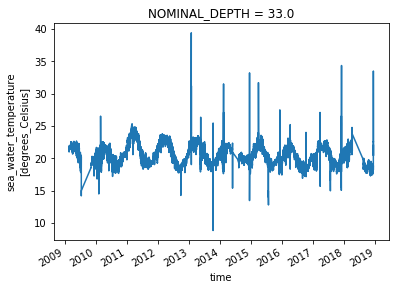

In [51]:
%%time
temp33.plot()

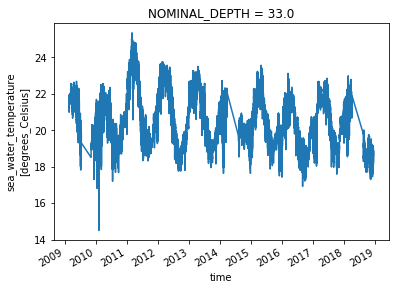

In [52]:
# Let's get just the good data
temp33[rot_33.TEMP_quality_control == 1].plot()